## Autor: Claudio Honorato Junior

Este trabalho faz parte da Monografia apresentada ao Departamento de Ciências de Computação do Instituto de Ciências Matemáticas e de Computação, Universidade de São Paulo - ICMC/USP, como parte dos requisitos para obtenção do título de Especialista em Inteligência Artificial e Big Data.

## Classificação de Objetos Celestes e Espectros Estelares com Perceptron 

Este trabalho propõe o uso de Redes Neurais Multicamadas (MLP) para a classificação de 
objetos astronômicos com base em dados espectroscópicos do Sloan Digital Sky Survey (SDSS). 
A pesquisa aborda três objetivos principais: (i) classificar objetos celestes em estrelas, galáxias 
e quasares; (ii) subclassificar estrelas conforme a classificação espectral de Harvard, com base 
na temperatura superficial. O modelo MLP foi comparado com algoritmos tradicionais como 
SVM, KNN, Regressão Logística, Random Forest e Naive-Bayes, entre outros, avaliando seu desempenho por 
meio de métricas como acurácia, precisão, recall e F1-score. A metodologia incluiu limpeza, 
normalização e seleção de features espectrais, além de técnicas de validação cruzada para 
garantir a robustez dos resultados. Os achados mostram que redes neurais profundas podem 
ser eficazes na análise de espectros astronômicos, oferecendo uma alternativa promissora 
para o tratamento de grandes volumes de dados no contexto da astrofísica moderna.

#### Neste notebook: (ii) subclassificar estrelas conforme a classificação espectral de Harvard

## Classification of Celestial Objects and Stellar Spectra with Perceptron

This work proposes the use of Multilayer Neural Networks (MLP) for the classification of 
astronomical objects based on spectroscopic data from the Sloan Digital Sky Survey (SDSS). The 
research addresses three main objectives: (i) to classify celestial objects into stars, galaxies, 
and quasars; (ii) to subclassify stars according to the Harvard spectral classification, based on 
surface temperature. The MLP model was compared with traditional algorithms such as SVM, 
KNN, Logistic Regression, Random Forest, and Naive-Bayes, between others, evaluating its performance 
through metrics such as accuracy, precision, recall, and F1-score. The methodology included 
spectral cleaning, normalization, and feature selection, as well as cross-validation techniques 
to ensure the robustness of the results. The findings show that deep neural networks can be 
effective in the analysis of astronomical spectra, offering a promising alternative for the 
treatment of large volumes of data in the context of modern astrophysics.

#### In this notebook: (ii) subclassify stars according to the Harvard spectral classification



### NOTEBOOK DE TRATAMENTO E PREPARAÇÃO DOS DADOS
#### O objetivo deste notebook é preparar os dados para serem consumidos pelo segundo notebook chamado "tcc_02_treinamento_EspectrosEstelares".


In [0]:
pip install SMOTE imblearn

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from pyspark.sql.functions import when, col, log1p, substring, trim, length
from pyspark.sql import SparkSession
from imblearn.over_sampling import SMOTE

In [0]:
# Codigo para executar no DATABRICKS

# Definir caminhos no DBFS
base_path = "dbfs:/FileStore/classification/astronomical_objects/"
pasta_bronze = f"{base_path}bronze"
pasta_silver = f"{base_path}silver/balanceado"
arquivo_pt1 = "espectros_estelares_Pt1.csv"
arquivo_pt2 = "espectros_estelares_Pt2.csv"
arquivo_tratado = "espectros_estelares_tratado"
arquivo_balanceado = "espectros_estelares_balanceado"

# Criar pastas usando dbutils
try:
    dbutils.fs.mkdirs(pasta_bronze)
    dbutils.fs.mkdirs(pasta_silver)
    print(f"Pastas criadas com sucesso em: {base_path}")
except Exception as e:
    print(f"Erro ao criar pastas: {e}")

# Verificar estrutura criada
print("\nEstrutura de pastas:")
print(f"Bronze: {pasta_bronze}")
print(f"Silver: {pasta_silver}")
print(f"Arquivos esperados: {arquivo_pt1}, {arquivo_pt2}, {arquivo_tratado}, {arquivo_balanceado}")


Pastas criadas com sucesso em: dbfs:/FileStore/classification/astronomical_objects/

Estrutura de pastas:
Bronze: dbfs:/FileStore/classification/astronomical_objects/bronze
Silver: dbfs:/FileStore/classification/astronomical_objects/silver/balanceado
Arquivos esperados: espectros_estelares_Pt1.csv, espectros_estelares_Pt2.csv, espectros_estelares_tratado, espectros_estelares_balanceado


In [0]:
 # Criar SparkSession
spark = SparkSession.builder \
     .appName("TCC") \
     .getOrCreate()

# Lendo arquivos bruto
df_pt1 = spark.read.csv(
    pasta_bronze + "/" + arquivo_pt1,
    header=True,
    inferSchema=True,
)

df_pt2 = spark.read.csv(
    pasta_bronze + "/" + arquivo_pt2,
    header=True,
    inferSchema=True,
)

# Unindo os 2 arquivos em 1 dataFrame consolidado
df_total = df_pt1.union(df_pt2) # colunas e ordem iguais

In [0]:
print(df_pt1.count())
print(df_pt2.count())
print(df_total.count())

500000
500000
1000000


In [0]:
# Salvando em dataframe temporario
df_total.createOrReplaceTempView("temp_objects_all")

# Selecionando apenas as colunas necessárias
# Nota: As colunas que foram eliminadas são os metadados dos espectros
df_stars = spark.sql(

    """
    SELECT *
    FROM temp_objects_all 
    WHERE class = 'STAR'
    """
)

display(df_stars.limit(5))

specObjID_p,skyVersion,run,rerun,camcol,field,obj,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,z,subclass,class,specObjID_g,spectrotype,redshift,oii_3726_flux,oiii_5007_flux,h_alpha_flux,oii_3726_chisq,oiii_5007_chisq,h_alpha_chisq,oii_3726_inst_res,oiii_5007_inst_res,h_alpha_inst_res
444747260668962816,2,4263,301,2,219,107,19.77458,18.71798,18.26378,18.12939,18.06005,20.03711,19.02617,18.60104,18.47951,18.3892,19.82929,18.8066,18.36399,18.2177,18.1572,11.70096,30.01618,45.12348,51.63157,54.58067,-4.929916E-4,G0,STAR,444747260668962816,STAR,-4.929916E-4,0.0,-1.676839,-2.866498,0.0,0.4853574,0.4917528,0.0,65.35149,60.4991
448161794129684480,2,4263,301,2,245,586,23.48041,22.50569,21.81294,22.07727,21.15533,22.81447,21.81223,21.30359,21.12966,20.74878,24.74747,20.67699,19.92125,19.87232,19.30485,-0.02913845,5.358974,10.75091,11.245,18.94088,-0.00401863,CarbonWD,STAR,448161794129684480,STAR,-0.00401863,0.0,-1.842582,-3.370186,0.0,0.6317857,1.244059,0.0,63.61694,59.97521
444888822791038976,2,4263,301,5,217,2,17.83314,16.58527,16.17703,15.98609,15.95485,18.12552,16.88404,16.45157,16.28804,16.24422,17.87065,16.63887,16.19801,16.04382,16.00212,71.07839,221.0307,331.7401,382.3607,397.3283,-1.019187E-4,F9,STAR,444888822791038976,STAR,-1.019187E-4,0.0,-8.628825,-44.47528,0.0,0.8065449,1.253405,0.0,56.45619,60.19514
451614260624123904,2,4263,301,5,284,232,22.21452,19.30329,17.7809,17.08503,16.67532,21.71563,19.12191,17.7011,17.06526,16.68988,22.36058,19.34396,17.71402,17.09931,16.58071,1.119781,18.29808,82.1089,144.6359,233.1918,1.077616E-4,K7,STAR,451614260624123904,STAR,1.077616E-4,0.0,6.408554,37.54849,0.0,1.686452,1.401969,0.0,57.89541,61.11086
447096092568348672,2,4263,301,6,235,44,17.16692,16.07712,15.94528,15.91447,15.92837,17.45454,16.37385,16.23666,16.21811,16.22274,17.1919,16.12073,15.99346,15.97863,16.0076,132.8126,356.2122,400.5115,406.021,395.3304,-5.267207E-4,A0,STAR,447096092568348672,STAR,-5.267207E-4,0.0,44.04014,-24.01361,0.0,0.6089046,3.303255,0.0,62.2846,62.56055


In [0]:
df_stars = df_stars.withColumn(
    "subclass",
    when(
        (length(trim(col("subclass"))) <= 4), # Agrupando as classes que tem 4 letras ou menos
        substring(trim(col("subclass")), 1, 1),
    ).otherwise(trim(col("subclass")))
)\
    .filter(col("subclass").rlike("^[A-Z]$")) ## Filtra apenas com uma letra

display(df_stars.groupBy("subclass").count().orderBy("count", ascending=False))

subclass,count
F,122711
K,60150
M,58517
A,33164
G,19401
W,7583
L,1409
C,1287
T,1131
O,967


In [0]:
# Astrônomos frequentemente usam índices de cor como u-g, g-r, r-i, i-z, que representam a diferença de magnitude entre bandas. 
# Essas diferenças estão associadas à temperatura e composição da estrela.

# 1. Diferenças de Magnitudes (Cores)
# Aplicando regra de "índices de cor"
df = df_stars.withColumn("u_g", col("psfMag_u") - col("psfMag_g")) \
             .withColumn("g_r", col("psfMag_g") - col("psfMag_r")) \
             .withColumn("r_i", col("psfMag_r") - col("psfMag_i")) \
             .withColumn("i_z", col("psfMag_i") - col("psfMag_z"))

# 2. Razões entre fluxos
df = df.withColumn("flux_oiii_halpha", col("oiii_5007_flux") / (col("h_alpha_flux") + 1e-6)) \
       .withColumn("flux_oii_oiii", col("oii_3726_flux") / (col("oiii_5007_flux") + 1e-6))

# 3. Log de fluxos
df = df.withColumn("log_flux_oiii", log1p(col("oiii_5007_flux"))) \
       .withColumn("log_flux_halpha", log1p(col("h_alpha_flux")))

# 4. Desvios entre magnitudes
df = df.withColumn("delta_psf_fiber_r", col("psfMag_r") - col("fiberMag_r")) \
       .withColumn("delta_psf_petro_r", col("psfMag_r") - col("petroMag_r"))

In [0]:
df.count()

307025

In [0]:
df_pd = df.toPandas()

df_pd.describe()

,specObjID_p,skyVersion,run,rerun,camcol,field,obj,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,z,specObjID_g,redshift,oii_3726_flux,oiii_5007_flux,h_alpha_flux,oii_3726_chisq,oiii_5007_chisq,h_alpha_chisq,oii_3726_inst_res,oiii_5007_inst_res,h_alpha_inst_res,u_g,g_r,r_i,i_z,flux_oiii_halpha,flux_oii_oiii,log_flux_oiii,log_flux_halpha,delta_psf_fiber_r,delta_psf_petro_r
count,3.070250e+05,307025.0,307025.000000,307025.0,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,3.070250e+05,307025.000000,307025.000000,3.070250e+05,3.070250e+05,307025.0,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,307025.000000,3.070250e+05,3.070250e+05,229668.000000,164231.000000,307025.000000,307025.000000
mean,2.136661e+18,2.0,4068.563293,301.0,3.443049,189.606084,308.151473,19.192407,17.675456,17.160600,16.526643,16.284819,19.402781,17.956675,17.417590,16.796959,16.553184,19.228083,17.743528,17.182873,16.556389,16.341405,34.756745,111.262061,179.582642,227.975110,262.854593,-0.000092,2.136661e+18,-0.000092,0.000368,-3.804410e+05,-1.773546e+06,0.0,1.355134,6.748606,4.736719,60.334733,60.900871,1.516951,0.514856,0.633957,0.241824,-5.980259e+08,3.683893e+02,1.465104,1.989721,-0.256990,-0.022273
std,8.047148e+17,0.0,1634.981607,0.0,1.590384,154.218934,393.787818,105.453165,103.870736,93.948427,105.414326,106.950360,106.992513,103.872880,95.673698,106.955489,108.469811,105.454524,102.286709,93.948841,105.414991,106.951826,237.729853,256.255123,425.510313,592.779024,676.094267,0.000418,8.047148e+17,0.000418,0.136418,1.810843e+08,1.000791e+09,0.0,1.892388,33.598251,19.121831,12.005716,11.811234,31.333494,44.288503,47.830612,47.823976,4.257365e+11,1.364183e+05,1.695039,2.021944,18.080244,0.277629
min,2.994935e+17,2.0,94.000000,301.0,1.000000,11.000000,2.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-15054.290000,-530.808900,-1195.235000,-938.574200,-181682.700000,-0.004309,2.994935e+17,-0.004309,0.000000,-9.773990e+10,-4.161700e+11,0.0,-1.925614,-215.215400,0.000000,0.000000,0.000000,-10020.203890,-10017.941730,-9.434040,-10016.733200,-2.191643e+14,-0.000000e+00,-10.850237,-9.375215,-7.989490,-11.508950
25%,1.357979e+18,2.0,2830.000000,301.0,2.000000,79.000000,92.000000,18.665670,17.310820,16.747460,16.457380,16.264490,18.974490,17.613020,17.054660,16.769420,16.579520,18.697520,17.333900,16.768240,16.479940,16.302070,2.109445,9.734794,18.921560,28.467550,37.083760,-0.000227,1.357979e+18,-0.000227,0.000000,-1.025461e+00,-1.062376e+01,0.0,0.697671,0.838320,0.000000,57.391250,61.321360,1.071130,0.369750,0.138100,0.042240,-4.855742e-01,0.000000e+00,0.297641,0.722361,-0.349030,-0.064730
50%,2.314929e+18,2.0,4192.000000,301.0,3.000000,148.000000,185.000000,20.144230,18.719940,18.024540,17.676400,17.439040,20.435010,19.008500,18.319650,17.982450,17.749270,20.161610,18.731300,18.039210,17.695350,17.476440,8.609465,32.154730,60.834840,83.493840,102.140700,-0.000059,2.314929e+18,-0.000059,0.000000,9.151852e-01,-3.777084e-01,0.0,0.999033,1.299928,0.000000,61.642830,62.418300,1.394730,0.581080,0.225360,0.112800,-8.631661e-02,0.000000e+00,1.357556,1.950446,-0.330560,-0.049400
75%,2.737172e+18,2.0,5061.000000,301.0,5.000000,246.000000,366.000000,21.685500,20.000820,19.282460,18.833100,18.531220,21.941280,20.286910,19.580060,19.142600,18.833820,21.684030,20.028580,19.307120,18.863600,18.576060,33.172750,11

In [0]:
# Substitui -9999 e '-9999' por null nas colunas apropriadas
for column_name, column_type in df.dtypes:
    if column_type in ['int', 'bigint', 'double', 'float']:
        df = df.withColumn(column_name, when(col(column_name) == -9999, None).otherwise(col(column_name)))
    elif column_type == 'string':
        df = df.withColumn(column_name, when(col(column_name) == '-9999', None).otherwise(col(column_name)))

# Lista de colunas a tratar
cols = df.columns

# Dropa so nulos tratados acima
df = df.dropna(subset=cols)

In [0]:
df_pd = df.toPandas()

df_pd.describe()

,specObjID_p,skyVersion,run,rerun,camcol,field,obj,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,z,specObjID_g,redshift,oii_3726_flux,oiii_5007_flux,h_alpha_flux,oii_3726_chisq,oiii_5007_chisq,h_alpha_chisq,oii_3726_inst_res,oiii_5007_inst_res,h_alpha_inst_res,u_g,g_r,r_i,i_z,flux_oiii_halpha,flux_oii_oiii,log_flux_oiii,log_flux_halpha,delta_psf_fiber_r,delta_psf_petro_r
count,1.105500e+05,110550.0,110550.000000,110550.0,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,1.105500e+05,110550.000000,110550.000000,1.105500e+05,1.105500e+05,110550.0,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,110550.000000,1.105500e+05,1.105500e+05,110550.000000,110550.000000,110550.000000,110550.000000
mean,2.055831e+18,2.0,3995.305862,301.0,3.429652,193.175278,358.863338,21.197798,19.525574,18.673936,18.157849,17.877790,21.408190,19.799584,18.954783,18.451051,18.171716,21.220590,19.563291,18.686839,18.179393,17.930426,17.909549,58.791896,112.257432,151.886692,182.906137,-0.000082,2.055831e+18,-0.000082,0.001023,4.007767e+05,1.439406e+06,0.0,1.445422,3.564225,4.350441,56.788259,57.183251,1.672224,0.851638,0.516088,0.280059,6.953975e+08,1.023109e+03,1.082393,1.597334,-0.280847,-0.012903
std,8.135810e+17,0.0,1612.212961,0.0,1.587334,155.681425,402.401411,2.034555,1.902606,1.717531,1.517455,1.510119,1.924377,1.869210,1.690398,1.488400,1.488947,2.115012,1.976440,1.749531,1.563846,1.590867,326.747616,265.558602,447.679716,503.532541,625.934937,0.000483,8.135810e+17,0.000483,0.227341,2.013063e+07,1.026800e+08,0.0,2.289077,20.409604,18.369080,18.330818,18.530031,0.875500,0.622749,0.705970,0.475378,2.311841e+11,2.273414e+05,1.656864,1.899602,0.370616,0.345080
min,2.994965e+17,2.0,109.000000,301.0,1.000000,11.000000,2.000000,13.564370,11.777210,10.762190,10.397500,11.408490,13.886890,13.485350,13.034940,13.293250,11.926390,10.184090,10.867770,10.262180,10.391560,10.482400,-506.549900,-530.808900,-69.821040,-902.350500,-108370.600000,-0.004309,2.994965e+17,-0.004309,0.000000,-9.999806e-01,-9.998783e-01,0.0,-1.925614,-28.049910,0.000000,0.000000,0.000000,-6.574510,-7.424790,-9.434040,-8.491220,-9.926114e+05,0.000000e+00,-10.850237,-9.013952,-7.989490,-8.396230
25%,1.275785e+18,2.0,2822.000000,301.0,2.000000,80.000000,126.000000,19.804780,18.233818,17.465390,17.098525,16.841983,20.096970,18.519645,17.747847,17.384957,17.134710,19.808550,18.235545,17.455950,17.088030,16.853765,0.993645,5.690842,10.936193,19.190742,25.454907,-0.000215,1.275785e+18,-0.000215,0.000000,0.000000e+00,2.469403e-01,0.0,0.611591,0.702022,0.000000,57.091712,61.068078,1.071010,0.497845,0.187153,0.079725,0.000000e+00,0.000000e+00,0.000000,0.220693,-0.349500,-0.069100
50%,2.155011e+18,2.0,4145.000000,301.0,3.000000,151.000000,225.000000,21.017200,19.461795,18.738005,18.319395,17.940740,21.290320,19.757110,19.034605,18.626070,18.254630,21.016975,19.482830,18.749520,18.336520,17.976315,3.914324,16.101090,31.636310,46.279075,64.478900,-0.000050,2.155011e+18,-0.000050,0.000000,1.637282e+00,3.765137e+00,0.0,1.001993,1.145208,0.000000,59.971130,62.249415,1.635310,0.780020,0.310145,0.180255,1.785940e-01,0.000000e+00,0.969749,1.561326,-0.329300,-0.050420
75%,2.703449e+18,2.0,4887.000000,301.0,5.000000,253.000000,455.000000,22.627095,20.581930,19.887667,19.263025,18.943797,22.768343,20.861695,20.176288,19.570322,19.242193,22.485982,20.611785,19.902700,19.292170,18.984655,11.926742,50.790212,104.140575,146.145625,181.336600,0.000075,2.703449e+18,0.000075,0.000000,6.154489e+00,1.308908e+

In [0]:
df.count()

110550

In [0]:
# Salvando arquivo parquet no diretorio TRATADO

caminho_completo_tratado = pasta_silver + "/" + arquivo_tratado
print(caminho_completo_tratado)

# salvar em parquet 
df.coalesce(1).write.mode("overwrite").parquet(caminho_completo_tratado)

dbfs:/FileStore/classification/astronomical_objects/silver/balanceado/espectros_estelares_tratado



#### Feature Enginering

In [0]:
# Etapa 3: Separar features e rótulos
X = df_pd.drop("class",axis=1)
X = X.drop("subclass",axis=1)
X = X.drop("spectrotype",axis=1)
y = df_pd["subclass"]

X.columns

Index(['specObjID_p', 'skyVersion', 'run', 'rerun', 'camcol', 'field', 'obj',
       'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'petroFlux_u', 'petroFlux_g', 'petroFlux_r', 'petroFlux_i',
       'petroFlux_z', 'z', 'specObjID_g', 'redshift', 'oii_3726_flux',
       'oiii_5007_flux', 'h_alpha_flux', 'oii_3726_chisq', 'oiii_5007_chisq',
       'h_alpha_chisq', 'oii_3726_inst_res', 'oiii_5007_inst_res',
       'h_alpha_inst_res', 'u_g', 'g_r', 'r_i', 'i_z', 'flux_oiii_halpha',
       'flux_oii_oiii', 'log_flux_oiii', 'log_flux_halpha',
       'delta_psf_fiber_r', 'delta_psf_petro_r'],
      dtype='object')

In [0]:
# Suponha que X seja seu dataframe de features e y a variável alvo (ex: 'class' ou 'subclass')
model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
model.fit(X, y)

# Pegando importâncias
importances = model.feature_importances_

Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

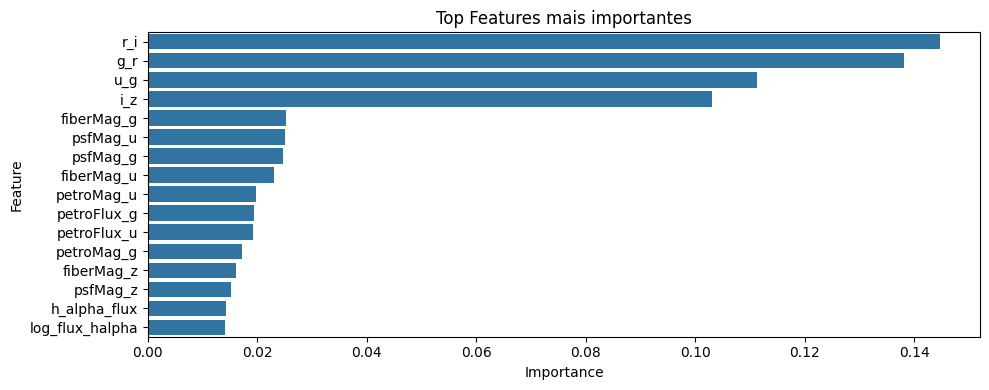

In [0]:
# Criando um dataframe organizado
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizando
plt.figure(figsize=(10, 4))
sns.barplot(data=feat_importance.head(16), x='Importance', y='Feature')
plt.title("Top Features mais importantes")
plt.tight_layout()
plt.show()


In [0]:
# Registrar as 4 features mais importantes + a classe
lista_features = feat_importance.head(4)['Feature'].tolist() + ['subclass']
print(lista_features)  

['r_i', 'g_r', 'u_g', 'i_z', 'subclass']


In [0]:
# Selecionar features
df = df.select(lista_features)
#display(df)

In [0]:
# df spark para df pandas
df_pd = df.toPandas()

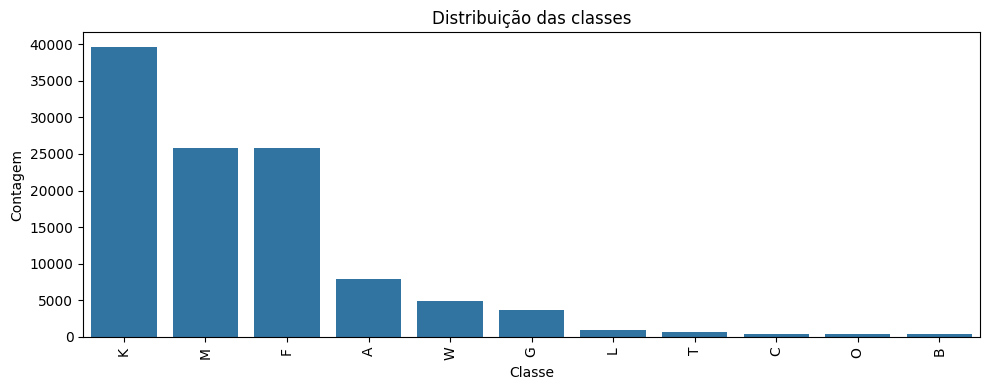

In [0]:
# Ordenar os rótulos da coluna 'subclass' pela contagem (do maior para o menor)
order = df_pd['subclass'].value_counts().index

# Plot com ordem definida
plt.figure(figsize=(10, 4))
sns.countplot(data=df_pd, x='subclass', order=order)
plt.title("Distribuição das classes")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.xticks(rotation=90)  # Roda os rótulos se tiver muitos
plt.tight_layout()
plt.show()

In [0]:
# Separar features e rótulos
X = df_pd.drop("subclass",axis=1)
y = df_pd["subclass"]

# Aplicar SMOTE no conjunto de treino para tratar desbalanceamento das classes
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

In [0]:
# Etapa 4: Juntar os dados balanceados
df_smote = pd.concat([X_smote, y_smote], axis=1)

# Converter para pandas e salvar localmente (sem Spark)
caminho_completo_balanceado = pasta_silver + "/" + arquivo_balanceado
print(caminho_completo_balanceado)


# Salvando em parquet o arquivo balanceado
spark.createDataFrame(df_smote)\
        .coalesce(1)\
        .write.mode("overwrite").parquet(caminho_completo_balanceado)


dbfs:/FileStore/classification/astronomical_objects/silver/balanceado/espectros_estelares_balanceado


Distribuição após SMOTE:
 Counter({'K': 39636, 'M': 39636, 'F': 39636, 'W': 39636, 'C': 39636, 'A': 39636, 'T': 39636, 'G': 39636, 'L': 39636, 'O': 39636, 'B': 39636})




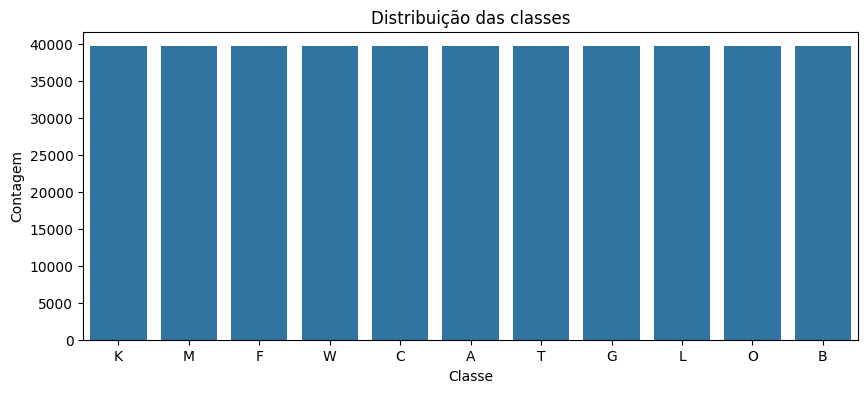

In [0]:
# Ver distribuição das classes codificadas
print("Distribuição após SMOTE:\n", Counter(y_smote))
print("\n")

# Plot codificado
plt.figure(figsize=(10, 4))
sns.countplot(x=y_smote) # seaborn
plt.title("Distribuição das classes")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

In [0]:
# Contagem do df original antes do balanceamento
df_pd.count()

r_i         110550
g_r         110550
u_g         110550
i_z         110550
subclass    110550
dtype: int64

In [0]:
# Contagem do df após o balanceamento
df_smote.count()

r_i         435996
g_r         435996
u_g         435996
i_z         435996
subclass    435996
dtype: int64